<a href="https://colab.research.google.com/github/TriannaHappy/satellite_correction/blob/main/LSTM_for_WeatherForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
!pip install netCDF4

In [ ]:
!pip install basemap

In [1]:
import pandas as pd
from pylab import *
import numpy as np
import glob
import warnings
import datetime
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from scipy.stats import stats, skew, pearsonr

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Input, LSTM, Dropout, Bidirectional
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

# Data Loading

In [2]:
pathpath='/content/drive/MyDrive/Data/bmkg data'
Bandung=pd.read_excel(pathpath+'/scrap/Stasiun Geofisika Bandung 2000-2024_scrap.xlsx')
Bandung_met=Bandung.iloc[8:-16,:]
Bandung_met.columns=Bandung.iloc[7]
Bandung_met.reset_index(drop=True, inplace=True)

for column in Bandung_met.columns[1:-1]:
    Bandung_met[column]=pd.to_numeric(Bandung_met[column])
    Bandung_met[column].replace(8888, np.nan, inplace=True)
    Bandung_met[column].replace(9999, np.nan, inplace=True)

Bandung_met=Bandung_met[:-3]

Bandung_met['Tanggal']=pd.to_datetime(Bandung_met['Tanggal'], format='%d-%m-%Y')
Bandung_met.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8861 entries, 0 to 8860
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Tanggal  8861 non-null   datetime64[ns]
 1   Tn       8474 non-null   float64       
 2   Tx       8531 non-null   float64       
 3   Tavg     8702 non-null   float64       
 4   RH_avg   8557 non-null   float64       
 5   RR       7565 non-null   float64       
 6   ss       8458 non-null   float64       
 7   ff_x     8742 non-null   float64       
 8   ddd_x    8732 non-null   float64       
 9   ff_avg   8745 non-null   float64       
 10  ddd_car  8578 non-null   object        
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 761.6+ KB


In [3]:
Bandung_met.isnull().mean()*100

7
Tanggal     0.000000
Tn          4.367453
Tx          3.724185
Tavg        1.794380
RH_avg      3.430764
RR         14.625889
ss          4.548019
ff_x        1.342964
ddd_x       1.455818
ff_avg      1.309107
ddd_car     3.193770
dtype: float64

# Feature Engineering

## Handling Missing Value

In [4]:
Bandung_met_copy=Bandung_met.set_index('Tanggal')
Bandung_met_copy['Tavg'] = Bandung_met_copy['Tavg'].interpolate(method='time')
Bandung_met_copy['Tx'] = Bandung_met_copy['Tx'].interpolate(method='time')
Bandung_met_copy['Tn'] = Bandung_met_copy['Tn'].interpolate(method='time')
Bandung_met_copy['RH_avg'] = Bandung_met_copy['RH_avg'].interpolate(method='time')
Bandung_met_copy['RR'] = Bandung_met_copy['RR'].fillna(0)
Bandung_met_copy.isnull().mean()*100

7
Tn         0.000000
Tx         0.000000
Tavg       0.000000
RH_avg     0.000000
RR         0.000000
ss         4.548019
ff_x       1.342964
ddd_x      1.455818
ff_avg     1.309107
ddd_car    3.193770
dtype: float64

## Handling Outlier

In [5]:
Bandung_met_copy

7,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ddd_x,ff_avg,ddd_car
Tanggal,,,,,,,,,,
2000-01-01,19.0,28.6,23.5,78.0,2.8,6.6,3.0,270.0,3.0,W
2000-01-02,20.0,28.8,22.8,83.0,0.0,6.1,3.0,270.0,3.0,W
2000-01-03,19.0,29.0,23.2,82.0,1.8,6.1,4.0,270.0,3.0,W
2000-01-04,19.0,26.0,21.5,92.0,5.0,0.5,0.0,0.0,0.0,N
2000-01-05,18.0,28.4,22.6,83.0,28.4,3.0,0.0,0.0,0.0,N
...,...,...,...,...,...,...,...,...,...,...
2024-03-31,20.6,32.0,26.1,73.0,0.0,6.1,2.0,10.0,0.0,C
2024-04-01,20.4,30.4,24.8,81.0,0.4,6.8,3.0,300.0,0.0,C
2024-04-02,21.8,30.4,25.9,81.0,11.6,5.9,3.0,250.0,1.0,C


In [6]:
Bandung_rr=Bandung_met_copy['RR']
Bandung_rr

Tanggal
2000-01-01     2.8
2000-01-02     0.0
2000-01-03     1.8
2000-01-04     5.0
2000-01-05    28.4
              ... 
2024-03-31     0.0
2024-04-01     0.4
2024-04-02    11.6
2024-04-03     5.6
2024-04-04     1.7
Name: RR, Length: 8861, dtype: float64

## Split Train and Test data

In [7]:
# Create X and y data with size of window=2
window = 14
X = []
y = []

for index in range(0, len(Bandung_rr)-window):
    X.append(Bandung_rr.squeeze()[index : window + index].values.tolist())
    y.append(Bandung_rr.squeeze()[window + index])

X = np.array(X)
y = np.array(y)

In [8]:
# make dataframe from X and y

X_y_df = pd.concat([pd.DataFrame(X, columns=['X'+str(x) for x in range (1,15)]), pd.DataFrame(y, columns=['y'])], axis=1)
X_y_df

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,y
0,2.8,0.0,1.8,5.0,28.4,19.1,8.8,32.0,24.9,19.5,0.5,40.0,0.5,0.0,4.0
1,0.0,1.8,5.0,28.4,19.1,8.8,32.0,24.9,19.5,0.5,40.0,0.5,0.0,4.0,16.0
2,1.8,5.0,28.4,19.1,8.8,32.0,24.9,19.5,0.5,40.0,0.5,0.0,4.0,16.0,0.5
3,5.0,28.4,19.1,8.8,32.0,24.9,19.5,0.5,40.0,0.5,0.0,4.0,16.0,0.5,0.0
4,28.4,19.1,8.8,32.0,24.9,19.5,0.5,40.0,0.5,0.0,4.0,16.0,0.5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8842,3.2,4.2,0.0,0.0,0.0,0.0,17.3,1.0,1.2,32.1,18.8,4.3,54.0,8.2,0.0
8843,4.2,0.0,0.0,0.0,0.0,17.3,1.0,1.2,32.1,18.8,4.3,54.0,8.2,0.0,0.4
8844,0.0,0.0,0.0,0.0,17.3,1.0,1.2,32.1,18.8,4.3,54.0,8.2,0.0,0.4,11.6
8845,0.0,0.0,0.0,17.3,1.0,1.2,32.1,18.8,4.3,54.0,8.2,0.0,0.4,11.6,5.6


In [9]:
# Calculate sizes for train, validation, and test sets
train_size = round(len(X) * 0.7)  # 70% for training
val_size = round(len(X) * 0.15)    # 15% for validation
test_size = len(X) - train_size - val_size  # Remaining for test

# Split the data
X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

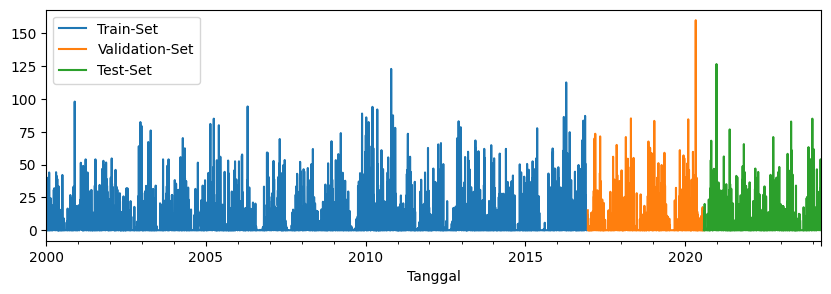

In [10]:
# Plot the train and test data after splitted
Bandung_rr.squeeze()[:train_size].plot.line(figsize=(10,3))
Bandung_rr.squeeze()[train_size:train_size + val_size].plot.line(figsize=(10,3))
Bandung_rr.squeeze()[train_size + val_size:].plot.line(figsize=(10,3))
plt.legend(['Train-Set', 'Validation-Set', 'Test-Set'])

## Feature Scaling

### Check Skewness

In [ ]:
def find_skewed_boundaries(df, variable, distance,skew):

    if ((skew>=0.5) | (skew<=-0.5)):

        IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

        lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
        upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    else:
        lower_boundary=df[variable].mean() - (df[variable].std()*3)
        upper_boundary=df[variable].mean() + (df[variable].std()*3)

    return upper_boundary, lower_boundary

# Function to create histogram and boxplot.
# This functions takes a dataframe (df) and the variable of interest as arguments.

def diagnostic_plots(df, variable):
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30, kde=True)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

In [ ]:
Bandung_rr=Bandung_rr.to_frame()

Rainfall
% Upper Outlier for quantity : 13.11%
% Lower Outlier for quantity : 0.00%
Skewness of quantity : 3.32


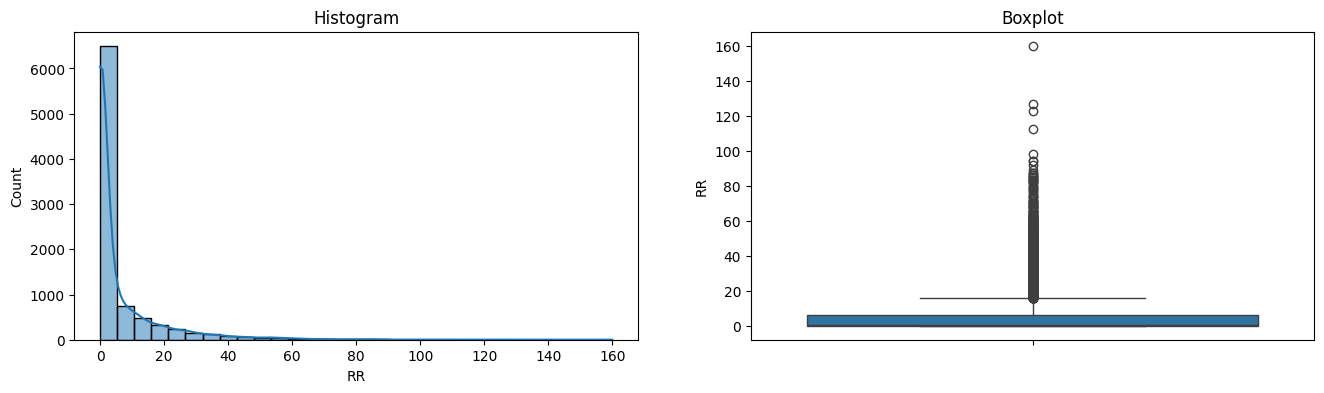

In [ ]:
# Check the outlier in the data

upper, lower=find_skewed_boundaries(Bandung_rr, 'RR', 1.5, Bandung_rr['RR'].skew())

out_u=(len(Bandung_rr[Bandung_rr['RR'] > upper])/len(Bandung_rr) * 100)
out_l=(len(Bandung_rr[Bandung_rr['RR'] < lower])/len(Bandung_rr) * 100)

print('Rainfall')
print('% Upper Outlier for quantity : {:.2f}%'.format(out_u))
print('% Lower Outlier for quantity : {:.2f}%'.format(out_l))
print('Skewness of quantity : {:.2f}'.format(Bandung_rr['RR'].skew()))
diagnostic_plots(Bandung_rr, 'RR')

### Feature Scaling

In [11]:
# Scaling the X data using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [12]:
# Load the train and validation using tensorflow pipeline
train_pipe = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(10).shuffle(100).prefetch(tf.data.AUTOTUNE)
val_pipe = tf.data.Dataset.from_tensor_slices((X_val,y_val)).batch(10)

In [17]:
X_train_scaled2 = X_train_scaled.reshape(-1, 1, 14)
X_val_scaled2  = X_val_scaled.reshape(-1, 1, 14)
X_test_scaled2 = X_test_scaled.reshape(-1, 1, 14)

y_train2 = y_train.reshape(-1, 1, 1)
y_val2 = y_val.reshape(-1, 1, 1)
y_test2 = y_test.reshape(-1, 1, 1)

model = Sequential()
model.add(LSTM(100, input_shape=(1, X_train_scaled2.shape[2]), return_sequences=True))
model.add(LSTM(5, input_shape=(1, X_train_scaled2.shape[2]), return_sequences=True))
model.compile(loss="mean_absolute_error", optimizer="adam", metrics= ['accuracy'])

history = model.fit(X_train,y_train,epochs=10, validation_data=(X_val_scaled2,y_val2))

Epoch 1/10


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 1, 14), found shape=(None, 14)


In [ ]:
timesteps = 1
X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], timesteps, X_train_scaled.shape[1]))
X_val_reshaped = np.reshape(X_val_scaled, (X_val_scaled.shape[0], timesteps, X_val_scaled.shape[1]))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], timesteps, X_test_scaled.shape[1]))

In [ ]:
# Assuming output_sequence_length is the same as the number of timesteps
output_sequence_length = 14

# Reshape y_train
y_train_reshaped = np.reshape(y_train, (y_train.shape[0], output_sequence_length))

# Reshape y_val
y_val_reshaped = np.reshape(y_val, (y_val.shape[0], output_sequence_length))

# Reshape y_test
y_test_reshaped = np.reshape(y_test, (y_test.shape[0], output_sequence_length))

ValueError: cannot reshape array of size 6193 into shape (6193,14)

In [ ]:
y_train.shape, X_train.shape

((6193,), (6193, 14))

In [ ]:
X_train_reshaped.shape

(6193, 1, 14)

In [ ]:
X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape

((6193, 14), (1327, 14), (1327, 14))

In [ ]:
X_train_scaled2.shape, X_val_scaled2.shape, X_test_scaled2.shape

((6193, 1, 14), (1327, 1, 14), (1327, 1, 14))

# Model Definition

In [ ]:
%%time
# Model Training with LSTM
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

model = Sequential()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.add(tf.keras.layers.BatchNormalization())
model.add(LSTM(13,return_sequences=True))
model.add(LSTM(256,return_sequences=True))
model.add(LSTM(512,return_sequences=False))
model.add(tf.keras.layers.Dropout(0.1))
model.add(Dense(5,activation='softmax'))

model.compile(loss='mse',optimizer='adam')


model_dnn_hist_1 = model.fit(train_pipe,
                         epochs=50,batch_size=100,
                         callbacks=[callback],
                         validation_data=val_pipe)

Epoch 1/50


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    Input 0 of layer "lstm" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 14)
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 14), dtype=float64)
      • training=True
      • mask=None


In [ ]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

# Model Training

# Model Evaluation